<a href="https://colab.research.google.com/github/arielwendichansky/DI_Bootcamp/blob/master/Week6/Day3/Daily_Challenge/Analysis_Of_Airplane_Crashes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as p
import scipy
import plotly.express as px
from scipy import stats, cluster
from scipy.optimize import minimize_scalar
from scipy.stats import skew, kurtosis, median_test,ttest_ind, norm
from plotnine import (ggplot,aes,geom_line,facet_wrap,labs, scale_x_datetime, element_text, theme_538)
from plotnine.data import meat

#Extract info Kaggle

In [3]:
! pip install -k kaggle
from google.colab import files
files.upload()


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -k


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arielwendichansky","key":"35f486beabeea6fcb79285bc7f95d018"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d nayansubedi1/airplane-crashes-and-fatalities-upto-2023

  0% 0.00/624k [00:00<?, ?B/s]
100% 624k/624k [00:00<00:00, 90.4MB/s]


In [6]:
! unzip 'airplane-crashes-and-fatalities-upto-2023.zip'

Archive:  airplane-crashes-and-fatalities-upto-2023.zip
  inflating: Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv  


# Initial Data Exploration

In [8]:
df = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv', encoding='ISO-8859-1')
df.head()

,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary
0,9/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,9/7/1909,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,7/12/1912,6:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,8/6/1913,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,9/9/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...


In [9]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   4998 non-null   object 
 1   Time                   3486 non-null   object 
 2   Location               4994 non-null   object 
 3   Operator               4988 non-null   object 
 4   Flight #               1329 non-null   object 
 5   Route                  4221 non-null   object 
 6   AC Type                4983 non-null   object 
 7   Registration           4724 non-null   object 
 8   cn/ln                  4330 non-null   object 
 9   Aboard                 4980 non-null   float64
 10  Aboard Passangers      4769 non-null   float64
 11  Aboard Crew            4772 non-null   float64
 12  Fatalities             4990 non-null   float64
 13  Fatalities Passangers  4756 non-null   float64
 14  Fatalities Crew        4757 non-null   float64
 15  Grou

Date                        0
Time                     1512
Location                    4
Operator                   10
Flight #                 3669
Route                     777
AC Type                    15
Registration              274
cn/ln                     668
Aboard                     18
Aboard Passangers         229
Aboard Crew               226
Fatalities                  8
Fatalities Passangers     242
Fatalities Crew           241
Ground                     42
Summary                    64
dtype: int64

In [10]:
df.describe()

,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground
count,4980.000000,4769.000000,4772.000000,4990.000000,4756.000000,4757.000000,4956.000000
mean,31.195984,27.009017,4.479254,22.373547,19.053827,3.578516,1.719128
std,45.534788,44.111609,3.483859,35.061741,34.146127,3.167922,55.540273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,3.000000,2.000000,4.000000,1.000000,2.000000,0.000000
50%,16.000000,12.000000,4.000000,11.000000,8.000000,3.000000,0.000000
75%,35.000000,30.000000,6.000000,25.000000,21.000000,5.000000,0.000000
max,644.000000,614.000000,61.000000,583.000000,560.000000,46.000000,2750.000000


# Cleaning data

In [11]:
cdata = df.copy()
# Delete columns that wont be used
columns_to_drop = ['Ground','Flight #', 'Summary']

cdata.drop(columns = columns_to_drop ,inplace=True )

# Handle missing values, for example, by filling them with appropriate values
# For categorical columns:
cdata['Operator'].fillna('Unknown', inplace=True)
cdata['AC Type'].fillna('Unknown', inplace=True)

# Assume for those rows where the  Aboard is null to be filled with the number of fatalities.
cdata['Aboard'] = cdata['Aboard'].fillna(cdata['Fatalities'])

# Remove duplicate records
cdata = cdata.drop_duplicates()


In [12]:
# Change types
cdata['Date'] = pd.to_datetime(cdata['Date'])

#Standarize text in location, operator, route, AC Type and registration
cdata['Location'] = cdata['Location'].str.title()
cdata['Route']= cdata['Route'].str.title()
cdata['AC Type'] = cdata['AC Type'].str.title()
cdata['Registration']= cdata['Registration'].str.title()

# Address inconsistent values, for example, by standardizing operator names
cdata['Operator'] = cdata['Operator'].str.strip().str.title()

# Check for data integrity issues

In [13]:
#split year and month from date
cdata['Year'] = cdata['Date'].dt.year
cdata['Month'] = cdata['Date'].dt.month

# Taking city and country from locattion string
cdata['City/Country'] = cdata['Location'].str.split(',').str[1]


#Place these columns in order
column_order = ['Date', 'Year', 'Month', 'Time', 'Location', 'City/Country']+[col for col in cdata.columns if col not in ['Date', 'Year', 'Month', 'Time', 'Location', 'City/Country']]
cdata = cdata[column_order]

# Calculating the fatality ratio
cdata['Fatality_Ratio (%)'] = (cdata['Fatalities'] / cdata['Aboard'])*100

<ipython-input-13-08cb59e58d8f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
cdata_geo = cdata.dropna(subset='City/Country')
cdata_geo = cdata_geo[cdata_geo['City/Country'] != 'NaN']

In [15]:
cdata = cdata[cdata['Fatalities'] != 0]
cdata = cdata[cdata['Aboard'] != 0]

In [16]:
cdata.isnull().sum()

Date                        0
Year                        0
Month                       0
Time                     1495
Location                    4
City/Country              177
Operator                    0
Route                     760
AC Type                     0
Registration              267
cn/ln                     656
Aboard                      8
Aboard Passangers         228
Aboard Crew               225
Fatalities                  8
Fatalities Passangers     240
Fatalities Crew           239
Fatality_Ratio (%)          8
dtype: int64

In [25]:
#Delete rows where the Aircraft model is not known
time = cdata.copy()

# Convert the 'Time' column to datetime with errors set to 'coerce' to handle invalid values
time['Time'] = pd.to_datetime(time['Time'], format='%H:%M', errors='coerce')


time.dropna(subset='Time', inplace=True)

morning_start = pd.to_datetime('00:00:00').time()
morning_end = pd.to_datetime('12:00:00').time()
evening_start = pd.to_datetime('12:00:00').time()
evening_end = pd.to_datetime('23:59:59').time()

def time_boundaries(time):
  if morning_start <=  time.time() <= morning_end:
    return 'Morning'
  elif evening_start <=  time.time() <= evening_end:
    return 'Evening'

# Apply the function to create a new column for the categorized time
time['time_bin'] = time['Time'].apply(time_boundaries)

#Analysis

In [17]:
print(cdata.shape)
print(cdata[['Aboard','Fatalities']].describe())
print(cdata[['Aboard','Fatalities']].sum())

(4923, 18)
            Aboard   Fatalities
count  4915.000000  4915.000000
mean     30.507833    22.714954
std      44.324332    35.218342
min       1.000000     1.000000
25%       7.000000     4.000000
50%      16.000000    11.000000
75%      34.000000    25.000000
max     644.000000   583.000000
Aboard        149946.0
Fatalities    111644.0
dtype: float64


We have 4923 crashes in our dataset.
The plane with the maximum number of passengers aboard had 644, not distinguished by tripulation or normal ones, and the maximum number of fatalities was 583 in a flight. In total, there were 149.946 passengers from which 111.644 died.

In [18]:
mean_aboard = cdata['Aboard'].mean()
median_aboard = cdata['Aboard'].median()
std__aboard = cdata['Aboard'].std()

print("The mean of passangers aboard were:", round(mean_aboard,2))
print("The median of passangers aboard were:", median_aboard)
print("The standart deviation of passangers aboard is:", round(std__aboard,2))

mean_fatalities = cdata['Fatalities'].mean()
median_fatalities = cdata['Fatalities'].median()
std_fatalities = cdata['Fatalities'].std()

print("\nThe mean of fatalities were:", round(mean_fatalities,2))
print("The median of fatalities were:", median_fatalities)
print("The standart deviation of fatalities is:", round(std_fatalities,2))

The mean of passangers aboard were: 30.51
The median of passangers aboard were: 16.0
The standart deviation of passangers aboard is: 44.32

The mean of fatalities were: 22.71
The median of fatalities were: 11.0
The standart deviation of fatalities is: 35.22


# Data Visualization

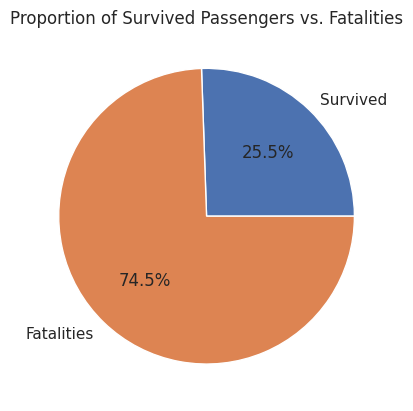

In [19]:
survived = (cdata['Aboard'].sum()) - (cdata['Fatalities'].sum())
fatal = (cdata['Fatalities'].sum())

labels = 'Survived', 'Fatalities'
fig, ax = plt.subplots()
ax.pie([survived,fatal], labels=labels, autopct='%1.1f%%')
plt.title('Proportion of Survived Passengers vs. Fatalities')
plt.show()

Unfortunately,  it is evident that the number of fatalities resulting from air accidents is higher than the number of survivors.

In [20]:
num_bins = 5
bin_boundaries = [0, 20, 60, 80, 100, 300]

cdata['Bin'] = pd.cut(cdata['Aboard'], bins=bin_boundaries)
# Convert the 'Bin' column to string
cdata['Bin'] = cdata['Bin'].astype(str)

cdata = cdata[cdata['Bin'] != 'nan']

fig = px.histogram(cdata, x='Bin', title='Airplane Size Distribution', labels={'Bin': 'Airplane Size', 'count': 'Frequency'})

fig.show()

Inside the dataset there is a higher distribution of smaller planes.

In [21]:
# Filtering out military flights
no_military = cdata[~cdata['Operator'].str.startswith('Military')]

# Filtering out private flights
no_military = no_military[no_military['Operator'] != 'Private']

# Filtering out flights with unknown operators
no_military = no_military[no_military['Operator'] != 'Unknown']

             Aboard  Fatalities  Survived  Survived %
(0, 20]     21346.0     17465.0    3881.0   18.181392
(20, 60]    36612.0     27636.0    8976.0   24.516552
(60, 80]    11605.0      8262.0    3343.0   28.806549
(80, 100]    9547.0      7266.0    2281.0   23.892322
(100, 300]  43777.0     28978.0   14799.0   33.805423


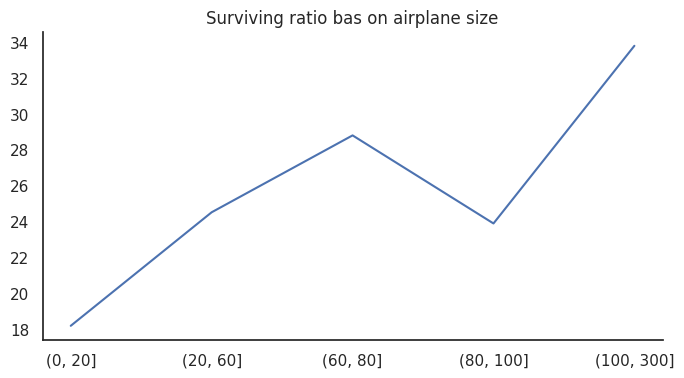

In [22]:
grouped_bin = no_military.groupby('Bin')[['Aboard', 'Fatalities']].sum()

grouped_bin['Survived'] = (grouped_bin['Aboard'])-(grouped_bin['Fatalities'])

grouped_bin['Survived %'] = (grouped_bin['Survived'] / grouped_bin['Aboard'])*100

# Define the custom list of bin labels
custom_order = ['(0, 20]', '(20, 60]', '(60, 80]', '(80, 100]', '(100, 300]']

# Convert the index to categorical type with the custom order
grouped_bin.index = pd.Categorical(grouped_bin.index, categories=custom_order, ordered=True)

# Sort the DataFrame by the index
grouped_bin = grouped_bin.sort_index()

print(grouped_bin)

grouped_bin['Survived %'].plot(kind='line', figsize=(8, 4), title='Surviving ratio bas on airplane size')
plt.gca().spines[['top', 'right']].set_visible(False)


It appears that larger airplanes (as categorized by the number of people aboard, represented by the 'Bin' column) tend to have higher survival rates. Larger airplanes may have more safety features, emergency exits, and evacuation procedures in place, which could contribute to higher survival rates compared to smaller aircraft.

In [23]:
fatalities_data = no_military['Fatalities']

fig = px.histogram(fatalities_data, x='Fatalities', title='Fatalities Distribution', labels={'Fatalities': 'Fatalities', 'count': 'Frequency', 'Airplane_size': 'Bin'})

fig.show()

Based on the dataset analysis, it is evident that a significant portion of the recorded tragedies involve low-capacity flights.

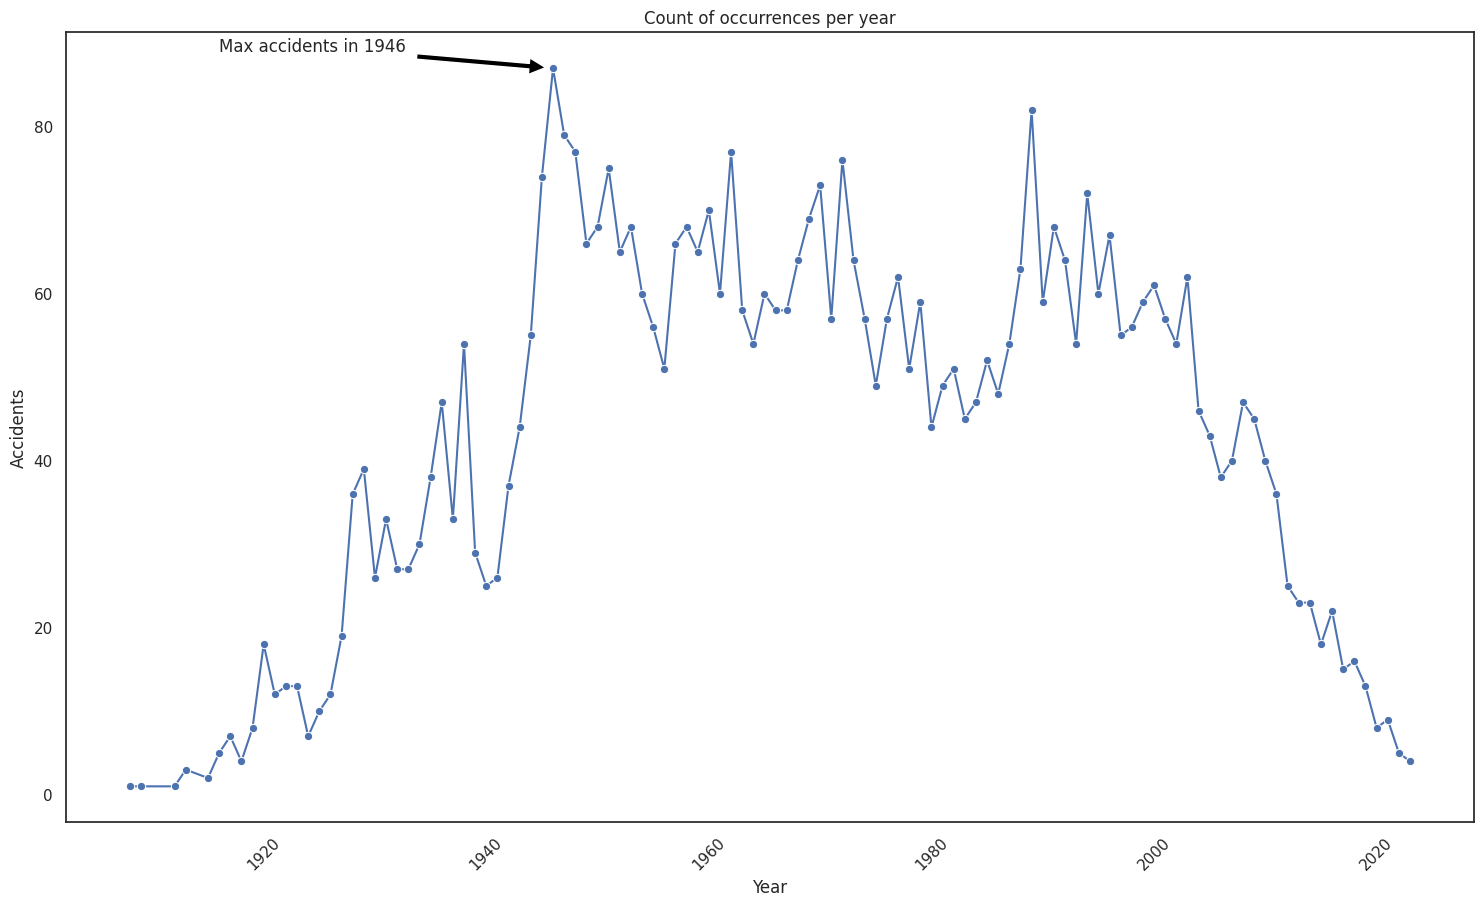

In [24]:
plt.figure(figsize=(15,9))
ax = sns.lineplot(data=cdata['Year'].value_counts(), marker='o')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.title("Count of occurrences per year")

# Find the maximum point
max_year = cdata['Year'].value_counts().idxmax()
max_count = cdata['Year'].value_counts().max()

# Annotate the maximum point
ax.annotate(f'Max accidents in {max_year}', xy=(max_year, max_count), xytext=(max_year - 30, max_count + 2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


We can see that there has been an increase in accidents since 1940, having a peak in 1946, and a decrease since 2000.

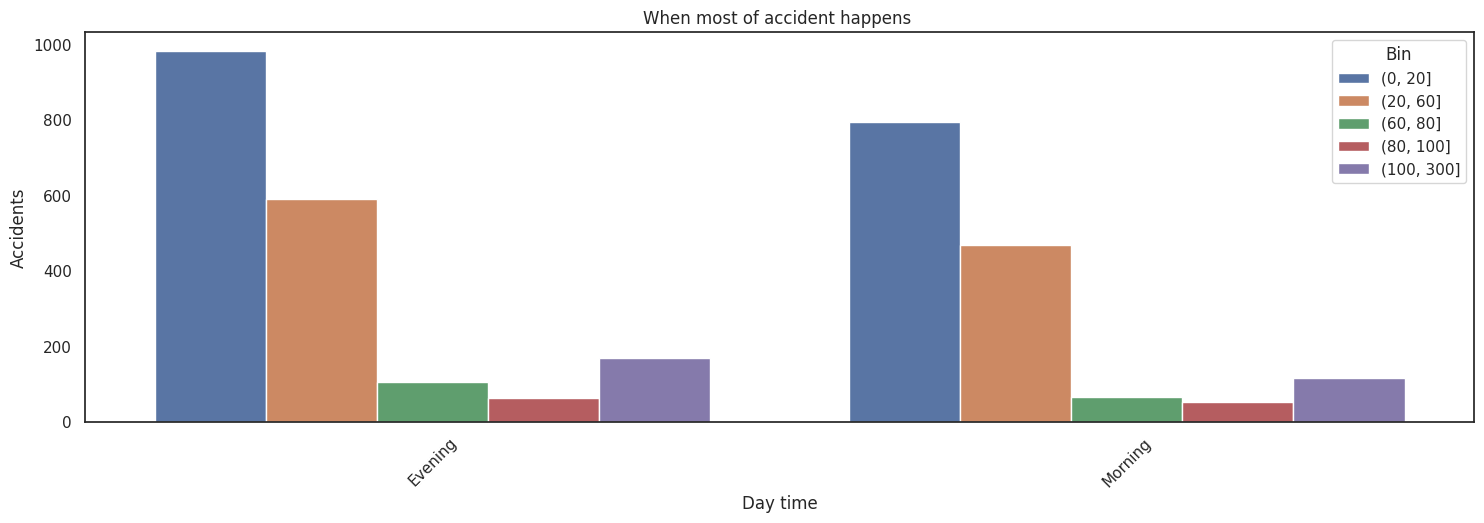

In [37]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=time , x='time_bin', hue='Bin')

plt.xlabel('Day time')
plt.ylabel('Accidents')
plt.title("When most of accident happens ")

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

Most of the accident seems to happen during evening hours

In [40]:
# Identify regions or countries with a high frequency of accidents
fig_accidents_by_location = px.scatter(no_military,
                                       x='City/Country',
                                       y='Aboard',
                                       title='Accidents Frequency by Location',
                                       labels={'Location': 'City/Country', 'Aboard': 'Number of Passengers'},
                                       color='Aboard',
                                       size='Aboard')
fig_accidents_by_location.update_layout(xaxis_title='Location', yaxis_title='Number of Passengers')

# Investigate if there are specific locations associated with higher fatalities
fig_fatalities_by_location = px.scatter(no_military.groupby('City/Country')['Fatalities'].sum().reset_index(),
                                         x='City/Country',
                                         y='Fatalities',
                                         title='Fatalities by Location',
                                         labels={'Location': 'City/Country', 'Fatalities': 'Total Fatalities'},
                                         color='Fatalities',
                                         size='Fatalities')
fig_fatalities_by_location.update_layout(xaxis_title='City/Country', yaxis_title='Total Fatalities')

fig_fatalities_by_aircraft = px.scatter(no_military.groupby('AC Type')['Fatalities'].sum().reset_index(),
                                        x='AC Type',
                                        y='Fatalities',
                                        title='Fatalities by Aircraft Model',
                                        labels={'Aircraft': 'AC Type', 'Fatalities': 'Total Fatalities'},
                                        color='Fatalities',
                                        size='Fatalities')
fig_fatalities_by_location.update_layout(xaxis_title='Aircraft Model', yaxis_title='Total Fatalities')

# Show the plots
fig_accidents_by_location.show()
fig_fatalities_by_location.show()
fig_fatalities_by_aircraft.show()

The country with the highest number of fatal accidents involving airplanes is Russia, with 7600 fatalities, more than double that of the second-ranking country, Brazil, with 2700 fatalities.

The aircraft model with the highest number of fatalities is the Douglas DC-3. One reason for this is its extensive use during World War II for transporting troops and cargo.

# Hypothesis test

The hypothesis being tested here is whether there is a significant difference in the number of fatalities between consecutive years

In [56]:
df_grouped = cdata.groupby('Year')

data_2017 = df_grouped.get_group(2017)['Fatalities']
data_2018 = df_grouped.get_group(2018)['Fatalities']
data_2019 = df_grouped.get_group(2019)['Fatalities']
data_2020 = df_grouped.get_group(2020)['Fatalities']
data_2021 = df_grouped.get_group(2021)['Fatalities']
data_2022 = df_grouped.get_group(2022)['Fatalities']
data_2023 = df_grouped.get_group(2023)['Fatalities']


result17_18 = ttest_ind(data_2017, data_2018)
result18_19 = ttest_ind(data_2018, data_2019)
result19_20 = ttest_ind(data_2019, data_2020)
result20_21 = ttest_ind(data_2020, data_2021)
result21_22 = ttest_ind(data_2021, data_2022)
result22_23 = ttest_ind(data_2022, data_2023)

print("Relation between years 2017-2018:",result17_18)
print("Relation between years 2018-2019:",result18_19)
print("Relation between years 2019-2020:",result19_20)
print("Relation between years 2020-2021:",result20_21)
print("Relation between years 2021-2022:",result21_22)
print("Relation between years 2022-2023:",result22_23)

Relation between years 2017-2018: TtestResult(statistic=-1.8429694026562171, pvalue=0.07557731423104586, df=29.0)
Relation between years 2018-2019: TtestResult(statistic=1.2408648913204074, pvalue=0.22532966589544182, df=27.0)
Relation between years 2019-2020: TtestResult(statistic=-0.9388423354175987, pvalue=0.35959446232248127, df=19.0)
Relation between years 2020-2021: TtestResult(statistic=1.0997542055261733, pvalue=0.2887766634594878, df=15.0)
Relation between years 2021-2022: TtestResult(statistic=-0.87735233924645, pvalue=0.3975204545121127, df=12.0)
Relation between years 2022-2023: TtestResult(statistic=0.4072200317841424, pvalue=0.6960111094476997, df=7.0)


The null hypothesis (H0) in this case would be that there is no significant difference in the number of fatalities between consecutive years.

For the year 2017-2018: The p-value (0.0756) is slightly greater than 0.05. But it's not strong enough to reject the null hypothesis at the 0.05 significance level.

For the rest of the years, the p-values are greater than 0.05, indicating that there is not enough evidence to reject the null hypothesis.

Therefore, based on these results, we cannot reject the null hypothesis.

 For the t-values, we can observe some fluctuations in the mean number of fatalities between consecutive years, but these differences are not large. Additionally, the negative t-values for some year pairs indicate that in those cases, the mean number of fatalities in the earlier year is lower than in the later year, while the positive t-values indicate the opposite.